# Flux Model

We explore the relation between flux observed at the Subaru telescope and the G-band flux reported by Gaia.

In [1]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from astropy.table import Table
from astropy.io import fits

### Important Note on Physical (Image) Coordinates
Both the object table and the Gaia tables below have x and y values which place the object in their images The coordinate values are increased by one to facilitate using these tables in DS9. The fits and DS9 conventions are to index arrays starting at 1. **Beware!**

### Object and Gaia tables
The `.fits` file below is bias= and overscan-subtracted by `no_bias.py`. `obj_tbl` came from running sep.extract on the image; '`gaia_tbl` from `xmatch.py`

In [2]:
data_path = '/home/kevin/repos/ReipurthBallyProject/fluxmodeldata'

#need the exposure time (bug, actually, no_bias.py should divide by the exp time to get electrons per second)
img_path = os.path.join(data_path,'SUPA01566780.fits')
exp_time = fits.getval(img_path, 'EXPTIME')

#objects extracted out of image via sep.extract
obj_tbl =  Table.read(os.path.join(data_path, 'SUPA01566780_objects.xml'))

#gaia query results in the neighborhood of the image
gaia_tbl = Table.read(os.path.join(data_path, 'SUPA01566780.xml'))

### Table that maps image objects to Gaia objects

The xmatch table below was produced by manually pairing image object with Gaia object. To reproduce, create an rgb frame in DS9, load a no_bias image into red and a false image into green. Then use the DS9 catalog tool to load the two xml files above, adjust the text so that it displays the object id with each object, then proceed with the pairing, recording the pairs in a .csv file. 

In [3]:
obj_map_path = os.path.join(data_path, 'obj_map.csv')
xmatch = Table.read(obj_map_path, delimiter='\s', comment='#')

#tack on identifiers
xmatch['obj_id'] = [f'obj_{i:04d}' for i in xmatch['obj']]
xmatch['GaiaId'] = [f'gaia_{i:04d}' for i in xmatch['gaia']]
xmatch

obj,gaia,obj_id,GaiaId
int64,int64,str8,str9
1,2771,obj_0001,gaia_2771
2,2755,obj_0002,gaia_2755
3,2803,obj_0003,gaia_2803
4,2754,obj_0004,gaia_2754
5,4415,obj_0005,gaia_4415
6,4083,obj_0006,gaia_4083
7,2836,obj_0007,gaia_2836
8,4426,obj_0008,gaia_4426
9,2806,obj_0009,gaia_2806


### Join the object and Gaia tables

using the mapping table from above

In [4]:
from astropy.table import join

# do this in two steps
xx=join(xmatch, gaia_tbl)
xmatch_tbl = join(xx, obj_tbl, keys='obj_id')
xmatch_tbl[:5]

obj,gaia,obj_id,GaiaId,source_id,ra,dec,parallax,pmra,pmdec,radial_velocity,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,phot_g_mean_flux,phot_bp_mean_flux,phot_rp_mean_flux,r_est,RA_MJD,DEC_MJD,x_1,y_1,thresh,npix,tnpix,xmin,xmax,ymin,ymax,x_2,y_2,x2,y2,xy,errx2,erry2,errxy,a,b,theta,cxx,cyy,cxy,cflux,flux,cpeak,peak,xcpeak,ycpeak,xpeak,ypeak,flag
,,,,,,,,,,,,,,,,,,deg,deg,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
int64,int64,str8,str9,int64,float64,float64,float64,float64,float64,float32,float32,float32,float32,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,int64
1,2771,obj_0001,gaia_2771,4066019597532160640,270.64686339766314,-24.373221093650276,2.0018252201751165,-0.47891786862956603,-11.729845042367296,--,16.522076,17.39112,15.500379,4635.713389387472,1509.9703953894975,5000.423591614373,499.5441110051164,270.6468475194534,-24.373736602468757,1032.9723362874156,141.23533842114728,12663.7099609375,18,16,1019,1023,141,144,1021.7292893319351,143.4918537174976,1.367072654498128,1.0224742474110307,-0.00768812062378732,5.019149526389222e-07,3.3029607327965273e-07,1.145498383214586e-10,1.1692920923233032,1.0110899209976196,-0.02229558862745762,0.73152095079422,0.9780610799789429,0.011000807397067547,399078.9375,440438.96875,33580.875,41761.86328125,1021,142,1021,142,0
2,2755,obj_0002,gaia_2755,4066019533130570112,270.6778924634641,-24.366947670627912,1.0535055998097655,-2.6619230651726475,-0.3980124317116792,34.35718,14.144041,14.537588,13.573222,41431.483942727704,20911.326955480952,29503.22463090857,949.2118505877642,270.67777012882135,-24.36695979373863,531.174014832679,262.8862619033626,12663.7099609375,78,70,502,511,251,260,507.6939188083178,256.7394642595332,3.18239142056893,3.8826969457907197,0.03167911255053113,3.6433662691693833e-08,3.620870153413762e-08,4.2263847940495817e-10,1.9708188772201538,1.783524990081787,1.525683045387268,0.31425461173057556,0.25757384300231934,-0.00512803765013814,5846763.0,5916600.5,198793.65625,200953.34375,507,256,507,256,0
3,2803,obj_0003,gaia_2803,4066019704929272832,270.65081738357924,-24.366691744626817,0.9598429863254055,-8.004068335275216,-10.24041537398166,--,17.044794,17.878338,16.208456,2864.3691897926415,964.0111556668584,2604.809583459055,1041.837065277029,270.65043453300956,-24.367141089135604,974.9555770767847,258.8892464597735,12663.7099609375,10,10,954,957,259,261,956.4831111921126,260.81939189326255,0.9060287441269783,0.5413725004703985,0.0011536707723722728,9.217040623567141e-07,4.917720081679976e-07,-2.874110427562616e-10,0.951857328414917,0.735777735710144,0.0031636792700737715,1.103720784187317,1.8471620082855225,-0.004704081919044256,170993.1875,197571.34375,21782.310546875,27362.568359375,955,260,955,260,0
4,2754,obj_0004,gaia_2754,4066019533130568704,270.68240945617475,-24.364731609683844,0.7973751646162972,0.5615834560142475,-2.1262754405397852,--,15.627954,16.195889,14.852952,10562.461834156971,4540.057413208089,9077.732942001629,1254.1148061480035,270.6824443179634,-24.3648205058875,455.3505110160663,301.1353530931869,12663.7099609375,39,36,429,435,293,299,433.06840371645075,296.4971018283413,2.229552083032109,2.025894083446466,-0.00597271256368348,1.7642404430211833e-07,1.46510908761983e-07,-3.298640405942683e-10,1.4932271242141724,1.4232776165008545,-0.0292936060577631,0.4485241174697876,0.4936131238937378,0.0026446650736033916,1386529.125,1442856.75,83751.359375,105641.09375,432,295,432,295,0
5,4415,obj_0005,gaia_4415,4066031387240664832,270.6107185854274,-24.362463471387187,0.9289395530353208,0.43287651706807506,0.861165787708065,-25.370111,14.671797,15.14417,14.027413,25481.68785330641,11960.494148845526,19417.4876204989,1076.4963088636805,270.61074717348606,-24.36241966200537,1619.4505296286334,341.768393871027,12663.7099609375,62,55,1620,

### Fit the flux model

The flux model predicts a Gaia star's G-band flux from the observed flux at the Subaru telescope. Intuitively, this seems backward: one would want to predict how much flux will be observed from the well-measured and published Gaia catalog flux data.

Because this model is used in part to pair image objects with Gaia records, we need the counter intuitive specification.

In [5]:
from sklearn.linear_model import LinearRegression

# independent and dependent variables
obs_flux = xmatch_tbl['flux']/exp_time # electrons per second
gaia_flux = xmatch_tbl['phot_g_mean_flux'] # electrons per second

#fit the model and calc the scores
mod = LinearRegression().fit( obs_flux.reshape(-1,1), gaia_flux)
y_hat = mod.predict(obs_flux.reshape(-1,1))
rsq = mod.score( obs_flux.reshape(-1,1), gaia_flux)
mod_rmse = np.sqrt(((gaia_flux - y_hat)**2).mean())
mod_nrmse = mod_rmse/gaia_flux.mean()

#create a fitted line for plotting
zz = np.linspace(obs_flux.min(),obs_flux.max(), 10000).reshape(-1,1)
fitted = mod.predict(zz)

print(f'Intercept: {mod.intercept_:.3f}, Slope: {mod.coef_[0]:.3f}, R-squared: {rsq:.4f}')

Intercept: 3690.180, Slope: 0.837, R-squared: 0.9691


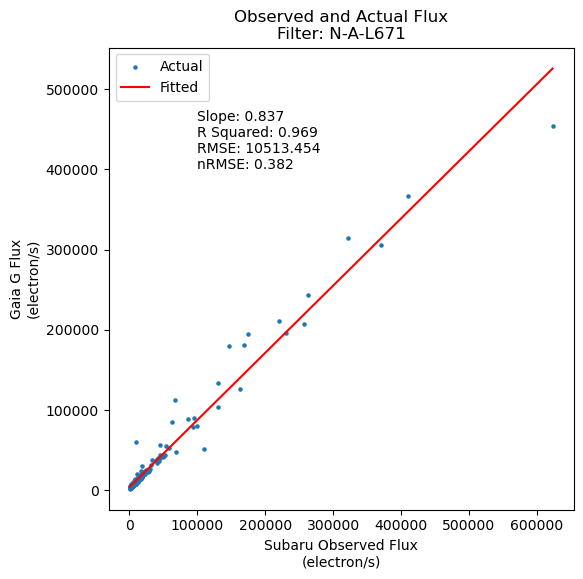

In [6]:
fig, ax = plt.subplots(figsize=(6,6))

ax.scatter( obs_flux,gaia_flux, s=5, label='Actual')
ax.plot(zz, fitted, color='red', label='Fitted')
ax.set_xlabel('Subaru Observed Flux\n(electron/s)')
ax.set_ylabel('Gaia G Flux\n(electron/s)')
ax.set_title('Observed and Actual Flux\nFilter: N-A-L671')
ax.text(100000, 400000, f'Slope: {mod.coef_[0]:.3f}\nR Squared: {rsq:.3f}'
       f'\nRMSE: {mod_rmse:.3f}\nnRMSE: {mod_nrmse:.3f}')
ax.legend()

### Reproduce the object table

Verify that we can reproduce the object table.

In [7]:
import sep

# img_path from above

# get the image
with fits.open(img_path) as f:
    img_hdr = f[0].header.copy()
    img_data = f[0].data.copy()
img_data = img_data.astype(float)

exp_time = img_hdr['EXPTIME'],
thresh = 250.0

bkg = sep.Background(img_data)
bkg_img = bkg.back() #2d array of background

img_noback = img_data - bkg
objects = sep.extract(img_noback, thresh=thresh, err = bkg.globalrms)
objects_df = pd.DataFrame(objects)
#objects_df.flux /= exp_time
objects_df['obj_id'] = [f'obj_{i:04d}' for i in range(len(objects_df))]

# add 1 to the x,y values to conform to Fits/DS9 indexing
objects_df['x'] += 1
objects_df['y'] += 1

test_tbl = Table.from_pandas(objects_df)

print(f'X coordinates match: {np.all(test_tbl["x"] == obj_tbl["x"])}')
print(f'Y coordinates match: {np.all(test_tbl["y"] == obj_tbl["y"])}')
print(f'flux match: {np.all(test_tbl["flux"] == obj_tbl["flux"])}')
print(f'size match: {np.all(test_tbl["npix"] == obj_tbl["npix"])}')


X coordinates match: True
Y coordinates match: True
flux match: True
size match: True


In [8]:
test_tbl[:5]

thresh,npix,tnpix,xmin,xmax,ymin,ymax,x,y,x2,y2,xy,errx2,erry2,errxy,a,b,theta,cxx,cyy,cxy,cflux,flux,cpeak,peak,xcpeak,ycpeak,xpeak,ypeak,flag,obj_id
float64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,int64,str8
12663.7099609375,43,26,108,115,9,17,112.03524628865311,12.541585009472026,1.511531763873057,4.17134014201973,-0.18494177623898178,1.6333418334169747e-08,3.3910195452580335e-08,-2.426355668609128e-09,2.0455164909362793,1.2242279052734375,-1.5017074346542358,0.6651890277862549,0.24103868007659912,0.05898403376340866,4340247.5,4343045.5,206017.1875,206948.390625,111,9,111,9,0,obj_0000
12663.7099609375,18,16,1019,1023,141,144,1021.7292893319351,143.4918537174976,1.367072654498128,1.0224742474110307,-0.00768812062378732,5.019149526389222e-07,3.3029607327965273e-07,1.145498383214586e-10,1.1692920923233032,1.0110899209976196,-0.02229558862745762,0.73152095079422,0.9780610799789429,0.011000807397067547,399078.9375,440438.96875,33580.875,41761.86328125,1021,142,1021,142,0,obj_0001
12663.7099609375,78,70,502,511,251,260,507.6939188083178,256.7394642595332,3.18239142056893,3.8826969457907197,0.03167911255053113,3.6433662691693833e-08,3.620870153413762e-08,4.2263847940495817e-10,1.9708188772201538,1.783524990081787,1.525683045387268,0.31425461173057556,0.25757384300231934,-0.00512803765013814,5846763.0,5916600.5,198793.65625,200953.34375,507,256,507,256,0,obj_0002
12663.7099609375,10,10,954,957,259,261,956.4831111921126,260.81939189326255,0.9060287441269783,0.5413725004703985,0.0011536707723722728,9.217040623567141e-07,4.917720081679976e-07,-2.874110427562616e-10,0.951857328414917,0.735777735710144,0.0031636792700737715,1.103720784187317,1.8471620082855225,-0.004704081919044256,170993.1875,197571.34375,21782.310546875,27362.568359375,955,260,955,260,0,obj_0003
12663.7099609375,39,36,429,435,293,299,433.06840371645075,296.4971018283413,2.229552083032109,2.025894083446466,-0.00597271256368348,1.7642404430211833e-07,1.46510908761983e-07,-3.298640405942683e-10,1.4932271242141724,1.4232776165008545,-0.0292936060577631,0.4485241174697876,0.4936131238937378,0.0026446650736033916,1386529.125,1442856.75,83751.359375,105641.09375,432,295,432,295,0,obj_0004


In [9]:
obj_tbl[:5]

thresh,npix,tnpix,xmin,xmax,ymin,ymax,x,y,x2,y2,xy,errx2,erry2,errxy,a,b,theta,cxx,cyy,cxy,cflux,flux,cpeak,peak,xcpeak,ycpeak,xpeak,ypeak,flag,obj_id
float64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,int64,str8
12663.7099609375,43,26,108,115,9,17,112.03524628865311,12.541585009472026,1.511531763873057,4.17134014201973,-0.18494177623898178,1.6333418334169747e-08,3.3910195452580335e-08,-2.426355668609128e-09,2.0455164909362793,1.2242279052734375,-1.5017074346542358,0.6651890277862549,0.24103868007659912,0.05898403376340866,4340247.5,4343045.5,206017.1875,206948.390625,111,9,111,9,0,obj_0000
12663.7099609375,18,16,1019,1023,141,144,1021.7292893319351,143.4918537174976,1.367072654498128,1.0224742474110307,-0.00768812062378732,5.019149526389222e-07,3.3029607327965273e-07,1.145498383214586e-10,1.1692920923233032,1.0110899209976196,-0.02229558862745762,0.73152095079422,0.9780610799789429,0.011000807397067547,399078.9375,440438.96875,33580.875,41761.86328125,1021,142,1021,142,0,obj_0001
12663.7099609375,78,70,502,511,251,260,507.6939188083178,256.7394642595332,3.18239142056893,3.8826969457907197,0.03167911255053113,3.6433662691693833e-08,3.620870153413762e-08,4.2263847940495817e-10,1.9708188772201538,1.783524990081787,1.525683045387268,0.31425461173057556,0.25757384300231934,-0.00512803765013814,5846763.0,5916600.5,198793.65625,200953.34375,507,256,507,256,0,obj_0002
12663.7099609375,10,10,954,957,259,261,956.4831111921126,260.81939189326255,0.9060287441269783,0.5413725004703985,0.0011536707723722728,9.217040623567141e-07,4.917720081679976e-07,-2.874110427562616e-10,0.951857328414917,0.735777735710144,0.0031636792700737715,1.103720784187317,1.8471620082855225,-0.004704081919044256,170993.1875,197571.34375,21782.310546875,27362.568359375,955,260,955,260,0,obj_0003
12663.7099609375,39,36,429,435,293,299,433.06840371645075,296.4971018283413,2.229552083032109,2.025894083446466,-0.00597271256368348,1.7642404430211833e-07,1.46510908761983e-07,-3.298640405942683e-10,1.4932271242141724,1.4232776165008545,-0.0292936060577631,0.4485241174697876,0.4936131238937378,0.0026446650736033916,1386529.125,1442856.75,83751.359375,105641.09375,432,295,432,295,0,obj_0004
